# 1D wavefunction propagation examples

This notebook contains various examples of 1D wavefunction propagation.

In [219]:
# Interactive widgets.
import ipywidgets as widgets

# Custom abTEM code to enable interactivity.
from abtem.visualize.interactive.artists import ImageArtist
from abtem.visualize.interactive.artists import LinesArtist
from abtem.visualize.interactive.artists import ScatterArtist
from abtem.visualize.interactive.utils import throttle
from abtem.visualize.interactive.canvas import Canvas
from abtem.visualize.utils import domain_coloring

In [220]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import hsv_to_rgb

from scipy.special import erf

In [345]:
# Define various functions for 1D wavefunction propagation examples
def color_complex(
    exit_wave, 
    amp_range=(0,1.0), 
    amp_power=1, 
    color_phase=True,
    ):
    """
    Generate a colored image from a complex exit wave.

    Inputs:
        exit_wave  - 2D complex number array
        amp_range - min and max amplitude
        amp_power -power law scaling for amlitude
        color_phase - boolean value for whether to colour by phase
    Outputs:
        im_rgb    - RGB output image
    
    """
    
    pha = np.angle(exit_wave)
    amp = np.abs(exit_wave)
    amp = np.clip((amp - amp_range[0]) / (amp_range[1] - amp_range[0]), 0, 1)
    if amp_power != 1:
        amp = amp ** amp_power

    if color_phase:
        # Generate blue-corrected hue colormap
        num_colors = 256
        t = np.linspace(0,1,num_colors)
        cmap = cm.hsv(t)
        # cmap = rgb_to_hsv(cmap[:,0:3])
        # c_scale = np.sin(np.maximum(1 - 3*np.abs(t - 0.667),0)*(np.pi/2))**2
        # cmap[:,1] = cmap[:,1] - 0.5 * c_scale
        # cmap = hsv_to_rgb(cmap)

        # Generate image
        im_rgb = np.ones((exit_wave.shape[0],exit_wave.shape[1],3))
        im_rgb[:,:,0] = np.mod(pha/(2*np.pi) + 0.5,1)
        im_rgb[:,:,2] =  amp

        # correct blue values from hue map
        c_scale = np.sin(np.maximum(1 - 6*np.abs(im_rgb[:,:,0] - 0.667),0)*(np.pi/2))**2
        im_rgb[:,:,1] = im_rgb[:,:,1]*(1 - 0.333*c_scale)
        im_rgb[:,:,2] = im_rgb[:,:,2]*(1 + 0.333*c_scale)

        # correct green values (and lime-green / yellow)
        c_scale = np.sin(np.maximum(1 - 4*np.abs(im_rgb[:,:,0] - 0.333),0)*(np.pi/2))**2
        im_rgb[:,:,2] = im_rgb[:,:,2]*(1 - 0.167*c_scale)      

        # Output image
        im_rgb[:,:,2] = np.clip(im_rgb[:,:,2], 0, 1)
        im_rgb = hsv_to_rgb(im_rgb)
    else:
        im_rgb = np.tile(amp[..., None], [1, 1, 3])
  
    return im_rgb


def wavefunction_prop(
    pot,
    psi=None,
    slice_thickness = 1.0,
    pixel_size = 0.1,
    wavelength = 0.02,
    band_limit = 0.25,
    normalize_rows_mean = False,
    normalize_rows_max = False,
    ):
    """
    This function propagates a wavefunction vertically from the top row through the image array pot.
    If no psi wavefunction is specified, we assume plane wave initial condition.
    
    Inputs:
        
    Outputs:
        
    
    """    
    
    # coords
    q = np.fft.fftfreq(pot.shape[1],pixel_size)
    prop = np.exp((-1*1j*np.pi*wavelength*slice_thickness)*q**2)
    
    # band limit
    q = np.fft.fftfreq(pot.shape[1], 1.0)
    prop = prop * (np.abs(q) < band_limit)
    
    # initial wavefunction if needed
    if psi is None:
        psi = np.ones(pot.shape[1], dtype='complex')
    else:
        psi = psi.astype('complex')
        
    # init output
    psi_all = np.zeros(pot.shape, dtype='complex')
    
    # Loop over all rows
    for a0 in range(pot.shape[0]):
        psi = np.fft.ifft(np.fft.fft(psi) * prop) * pot[a0,:]
        
        if normalize_rows_mean:
            psi_all[a0,:] = psi / np.mean(np.abs(psi))
        elif normalize_rows_max:
            psi_all[a0,:] = psi / np.max(np.abs(psi))        
        else:
            psi_all[a0,:] = psi
    
    return psi_all


def make_pn_junction(
    image_size = (256,384),
    vert_range = (16,17),
    horiz_pos = (0.25,0.75),
    junction_width = 32,
    phase_shift = np.pi/4,
    ):
    """
    This function makes a complex potential image representing 2 PN junctions
    
    Inputs:
        
    Outputs:
        
    
    """
    
    # init
    pot = np.ones(image_size, dtype='complex')
    
    # coords
    y = np.arange(image_size[1])
    y_mid = np.array(horiz_pos) * image_size[1]
    
    # Generate the 2 junctions
    pot[vert_range[0]:vert_range[1],:] = pot[vert_range[0]:vert_range[1],:] * np.exp((1j*phase_shift)*(0.5+0.5*erf((y-y_mid[0])/(0.5*junction_width))))
    pot[vert_range[0]:vert_range[1],:] = pot[vert_range[0]:vert_range[1],:] * np.exp((-1j*phase_shift)*(0.5+0.5*erf((y-y_mid[1])/(0.5*junction_width))))
    
    return pot


def make_diffraction_grating(
    image_size = (256,384),
    vert_range = (16,17),
    gap_num = 2,
    gap_size = 8,
    gap_spacing = 32,
    barrier_opacity=0,
    ):
    """
    This function makes a complex potential image representing a diffraction grating.
    
    Inputs:
        
    Outputs:
        
    
    """
    
    # init
    pot = np.ones(image_size)
    pot[vert_range[0]:vert_range[1],:] = barrier_opacity

    # Add gaps
    g = np.arange(gap_num)
    g = (g - np.mean(g)) * gap_spacing + image_size[1]/2
    for a0 in range(gap_num):
        pot[vert_range[0]:vert_range[1],
            np.round((g[a0] - gap_size/2)).astype('int'):(np.round(g[a0] + gap_size/2)).astype('int')] = 1
    
    return pot


def make_phase_wedge(
    image_size = (256,384),
    phase_shift=np.pi/2,
    wedge_width=256,
    wedge_height=128,
    wedge_pos=None,
    ):
    """
    This function makes a complex potential image representing a phase wedge.  Default position is the middle of the cell
    
    Inputs:
        
    Outputs:
        
    
    """

    # init
    pot = np.ones(image_size, dtype='complex')
    p = np.exp(1j*phase_shift)
    
    # position of the wedge
    if wedge_pos is None:
        wedge_pos = np.array(image_size) / 2
    x_inds = np.arange(wedge_height)
    x_inds = np.round(wedge_pos[0] - wedge_height/2 + x_inds).astype('int')
    y1 = np.round(wedge_pos[1] + wedge_width/2).astype('int')
    
    for a0 in range(wedge_height):
        y0 = np.round(wedge_pos[1] - wedge_width/2 + a0/wedge_height*wedge_width).astype('int') 
        pot[x_inds[a0],y0:y1] = p
        
    return pot



def make_gaussian_object(
    image_size = (256,384),
    xy_pos=None,
    sigma=4,
    amplitude=1,
    phase_shift=np.pi/2,
    ):
    """
    This function makes a Gaussian object.  Default position is in the center of the cell.
    
    Inputs:
        
    Outputs:
        
    
    """

    # init
    pot = np.ones(image_size, dtype='complex')
    
    if xy_pos is None:
        xy_pos = np.array(image_size).astype('float') / 2.0
    
    y = np.arange(image_size[1]) - xy_pos[1]
    x_ind = np.round(xy_pos[0]).astype('int')
    if phase_shift != 0:
        pot[x_ind,:] = pot[x_ind,:]*np.exp(1j*phase_shift*np.exp(y**2/(-2*sigma**2)))
    if amplitude != 1:
        pot[x_ind,:] = pot[x_ind,:]*(1 - (1-amplitude)*np.exp(y**2/(-2*sigma**2)))  
    
    return pot

def STEM_probe(
    wavefunction_size = 384,
    probe_max_mrads = 20.0,
    pixel_size = 0.1,
    probe_pos = None,
    probe_tilt = 0,
    C1 = 0.0,
    C3 = 0.0,
    wavelength = 0.02,
    ):
    """
    This function generates a STEM probe.  Default position is middle of the cell.
    
    Inputs:
        
    Outputs:
        
    
    """
        
    # coords
    q = np.fft.fftfreq(wavefunction_size, pixel_size)
    probe_max_inv_ang = (probe_max_mrads / 1000) / wavelength
    psi = (np.abs(q) <= probe_max_inv_ang).astype('complex')
    
    # normalize
    psi = np.fft.ifft(psi)
    psi = psi / np.max(np.abs(psi))
    psi = np.fft.fft(psi)

    # probe shift
    if probe_pos is None:
        probe_pos = wavefunction_size * pixel_size * 0.5
    psi = psi * np.exp((-2j*np.pi*probe_pos)*q)
    
    # Probe tilt
    if probe_tilt != 0:
        psi = np.roll(psi,np.array(probe_tilt).astype('int'))
    
    # aberrations
    psi = psi * np.exp((-1j*(
        (np.pi*wavelength*C1)*q**2 + ((np.pi/2)*(wavelength**3)*C3)*q**4)))
    
    # Realspace
    psi = np.fft.ifft(psi)
        
    return psi

def plane_wave(
    wavefunction_size=384,
    tilt_angle=0,
    ):
    """
    This function generates a plane wave, potentially with a tilt.
    
    Inputs:
        
    Outputs:
        
    
    """
    
    # Generate wavefunction
    psi = np.zeros(wavefunction_size)
    psi[-tilt_angle] = wavefunction_size

    # Realspace
    psi = np.fft.ifft(psi)
        
    return psi
    

def plot_image(im_rgb):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.imshow(
        im_rgb,
        )
    ax.axis("off")
    plt.show()

# Plane wave passing through a slit

In [346]:
# Canvases are layout areas where things are plotted.
canvas = Canvas(height=400, width=600, fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})
canvas.y_scale.reverse = True

# Artists do the plotting.
artist = ImageArtist(autoadjust_colorscale = False, rgb=True)
canvas.artists = {'image': artist}

# Defines an interactive slider for the H-H distances.
slider1 = widgets.IntSlider(description='Plane wave tilt', min=-60, max=60, value=0, step=2)
slider2 = widgets.IntSlider(description='Slit width', min=5, max=200, value=100, step=5)
slider3 = widgets.IntSlider(description='Opacity [%]', min=0, max=100, value=0, step=1)
check1 = widgets.Checkbox(value=False,description='Show Phase')

def slider_change(*args):
    tilt_angle = slider1.value
    gap_size = slider2.value
    barrier_opacity = slider3.value / 100.0
    
    psi = plane_wave(tilt_angle=tilt_angle)
    grating = make_diffraction_grating(
        vert_range = (64,65),
        gap_num=1, 
        gap_size=gap_size, 
        barrier_opacity=barrier_opacity)
    
    wave_function = wavefunction_prop(grating,psi, normalize_rows_max=False)
    artist.image = color_complex(wave_function.T, color_phase=check1.value, amp_range=[0,1.2])
            

# Activate an observer to receive the interaction.
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
slider3.observe(slider_change, 'value')
check1.observe(slider_change, 'value')

slider1.style = {'description_width': '100px'}
slider2.style = {'description_width': '100px'}
slider3.style = {'description_width': '100px'}
check1.style  = {'description_width': '100px'}

# Set up and display the widgets in a grid.
slider_change()
widgets.HBox([canvas.widget, widgets.VBox([slider1, slider2, slider3, check1])])

# Plane wave incident on an amplitude object

In [347]:
# Canvases are layout areas where things are plotted.
canvas = Canvas(height=400, width=600, fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})
canvas.y_scale.reverse = True

# Artists do the plotting.
# artist2 = ScatterArtist()
# canvas.artists = {'scatter': artist2}
artist = ImageArtist(autoadjust_colorscale = False, rgb=True)
canvas.artists = {'image': artist}

slider1 = widgets.FloatLogSlider(description='Gaussian Size', min=0, max=2, value=4, step=0.1)
slider2 = widgets.FloatSlider(description='Amplitude', min=0, max=1, value=0.0, step=0.05)
check1 = widgets.Checkbox(value=False,description='Show Phase')
# artist2.offsets(100,100)


def slider_change(*args):
    sigma = slider1.value
    amplitude = slider2.value
    
    grating = make_gaussian_object(
        xy_pos=[32,192],
        sigma=sigma,
        amplitude=amplitude,
        phase_shift=0,
    )
    
    wave_function = wavefunction_prop(grating, normalize_rows_max=False)
    artist.image = color_complex(wave_function.T, color_phase=check1.value, amp_range=[0,1.2])

# Activate an observer to receive the interaction.
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
check1.observe(slider_change, 'value')
slider1.style = {'description_width': '100px'}
slider2.style = {'description_width': '100px'}
check1.style  = {'description_width': '100px'}

# Set up and display the widgets in a grid.
slider_change()
widgets.HBox([canvas.widget, widgets.VBox([slider1, slider2, check1])])

# Plane wave incident on a phase object

In [348]:
canvas = Canvas(height=400, width=600, fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})
canvas.y_scale.reverse = True

artist = ImageArtist(autoadjust_colorscale = False, rgb=True)
canvas.artists = {'image': artist}

slider1 = widgets.FloatLogSlider(description='Gaussian Size', min=0, max=2, value=4, step=0.1)
slider2 = widgets.FloatSlider(description='Phase Shift [rads]', min=-4*np.pi, max=4*np.pi, value=np.pi/1, step=np.pi/32)
check1 = widgets.Checkbox(value=False,description='Show Phase')

def slider_change(*args):
    sigma = slider1.value
    phase_shift = slider2.value
    
    grating = make_gaussian_object(
        xy_pos=[32,192],
        sigma=sigma,
        phase_shift=phase_shift,
    )

    wave_function = wavefunction_prop(grating, normalize_rows_max=False)
    artist.image = color_complex(wave_function.T, color_phase=check1.value, amp_range=[0,1.2])

# Activate an observer to receive the interaction.
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
check1.observe(slider_change, 'value')
slider1.style = {'description_width': '120px'}
slider2.style = {'description_width': '120px'}
check1.style  = {'description_width': '120px'}

# Set up and display the widgets in a grid.
slider_change()
widgets.HBox([canvas.widget, widgets.VBox([slider1, slider2, check1])])

# Plane wave incident on a PN junction

In [349]:
canvas = Canvas(height=400, width=600, fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})
canvas.y_scale.reverse = True

artist = ImageArtist(autoadjust_colorscale = False, rgb=True)
canvas.artists = {'image': artist}

slider1 = widgets.FloatLogSlider(description='Junction Size', min=0, max=2.4, value=10, step=0.1)
slider2 = widgets.FloatSlider(description='Phase Shift [rads]', min=0*np.pi, max=4*np.pi, value=np.pi/1, step=np.pi/32)
check1 = widgets.Checkbox(value=False,description='Show Phase')



def slider_change(*args):
    junction_width = slider1.value
    phase_shift = slider2.value
    
    grating = make_pn_junction(
        image_size=(256,768),
        junction_width=junction_width,
        phase_shift=phase_shift,
    )

    wave_function = wavefunction_prop(grating, normalize_rows_max=False)
    artist.image = color_complex(wave_function[:,:384].T, color_phase=check1.value, amp_range=[0,1.2])

# Activate an observer to receive the interaction.
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
check1.observe(slider_change, 'value')
slider1.style = {'description_width': '120px'}
slider2.style = {'description_width': '120px'}
check1.style  = {'description_width': '120px'}

# Set up and display the widgets in a grid.
slider_change()
widgets.HBox([canvas.widget, widgets.VBox([slider1, slider2, check1])])

# STEM probe in vacuum

In [359]:
canvas = Canvas(height=400, width=600, fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})
canvas.y_scale.reverse = True

artist = ImageArtist(autoadjust_colorscale = False, rgb=True)
canvas.artists = {'image': artist}

slider1 = widgets.FloatSlider(description='Semiangle [mrads]', min=0, max=60, value=20, step=1)
slider2 = widgets.FloatSlider(description='Defocus [A]', min=-500, max=500, value=100, step=10)
slider3 = widgets.FloatSlider(description='C3 aber [mm]', min=0, max=0.1, value=0, step=0.005)
slider4 = widgets.FloatSlider(description='Probe position [A]', min=0, max=38.4, value=20, step=0.1)
slider5 = widgets.IntSlider(description='Probe tilt', min=-40, max=40, value=0, step=1)
check1 = widgets.Checkbox(value=False,description='Show Phase')

def slider_change(*args):
    probe_max_mrads = slider1.value
    C1 = -1*slider2.value
    C3 = 1e7*slider3.value
    probe_pos = slider4.value
    probe_tilt = slider5.value
    
    grating = np.ones((256,384))
    psi = STEM_probe(
        probe_max_mrads=probe_max_mrads,
        C1=C1,
        C3=C3,
        probe_pos=probe_pos,
        probe_tilt=probe_tilt,
    )
    wave_function = wavefunction_prop(grating, psi, normalize_rows_max=False)

    artist.image = color_complex(wave_function.T, color_phase=check1.value, amp_range=[0,1.2])

# Activate an observer to receive the interaction.
slider1.observe(slider_change, 'value')
slider2.observe(slider_change, 'value')
slider3.observe(slider_change, 'value')
slider4.observe(slider_change, 'value')
slider5.observe(slider_change, 'value')
check1.observe(slider_change, 'value')
slider1.style = {'description_width': '125px'}
slider2.style = {'description_width': '125px'}
slider3.style = {'description_width': '125px'}
slider4.style = {'description_width': '125px'}
slider5.style = {'description_width': '125px'}
check1.style  = {'description_width': '125px'}

# Set up and display the widgets in a grid.
slider_change()
widgets.HBox([canvas.widget, widgets.VBox([slider1, slider2, slider3, slider4, slider5, check1])])

### STEM probe + phase wedge

In [251]:
# plot_image(color_complex(wavefunction_prop(
#     make_phase_wedge(phase_shift=np.pi/8),
#     STEM_probe(probe_max_inv_ang=0.5),
#     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_phase_wedge(phase_shift=np.pi/4),
# #     STEM_probe(probe_max_inv_ang=0.5),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_phase_wedge(phase_shift=np.pi/2),
# #     STEM_probe(probe_max_inv_ang=0.5),
# #     normalize_rows_max=True)))

### STEM probes

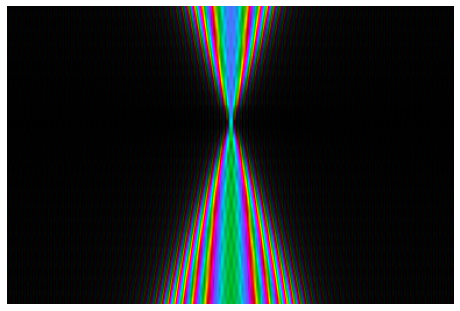

In [283]:
plot_image(color_complex(wavefunction_prop(
    np.ones((256,384)),
    STEM_probe(probe_max_inv_ang=2.0,
              C1=-1e2),
    normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     np.ones((256,384)),
# #     STEM_probe(probe_max_inv_ang=0.5),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     np.ones((256,384)),
# #     STEM_probe(probe_max_inv_ang=1.0),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     np.ones((256,384)),
# #     STEM_probe(probe_max_inv_ang=2.0),
# #     normalize_rows_max=True)))

### Single slit example

In [253]:
# plot_image(color_complex(wavefunction_prop(
#     make_diffraction_grating(gap_num=1, gap_size = 256),
#     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_num=1, gap_size = 64),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_num=1, gap_size = 16),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_num=1, gap_size = 4),
# #     normalize_rows_max=True)))

### Two slit example

In [254]:
# # slit spacing example
# plot_image(color_complex(wavefunction_prop(
#     make_diffraction_grating(gap_spacing = 180),
#     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_spacing = 140),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_spacing = 100),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_spacing = 60),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_spacing = 20),
# #     normalize_rows_max=True)))

### Many gap example

In [255]:
# plot_image(color_complex(wavefunction_prop(
#     make_diffraction_grating(gap_num=16, gap_spacing=16, gap_size = 4),
#     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_num=16, gap_spacing=12, gap_size = 4),
# #     normalize_rows_max=True)))

# # plot_image(color_complex(wavefunction_prop(
# #     make_diffraction_grating(gap_num=16, gap_spacing=8, gap_size = 4),
# #     normalize_rows_max=True)))

## Interactive slit interference example

In [256]:
# # Interactive widgets.
# import ipywidgets as widgets

# # Custom abTEM code to enable interactivity.
# from abtem.visualize.interactive.artists import ImageArtist
# from abtem.visualize.interactive.artists import LinesArtist
# from abtem.visualize.interactive.utils import throttle
# from abtem.visualize.interactive.canvas import Canvas
# from abtem.visualize.utils import domain_coloring

In [257]:
# # Canvases are layout areas where things are plotted.
# canvas = Canvas(height=400, width=600, fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})
# canvas.y_scale.reverse = True

# # Artists do the plotting.
# artist = ImageArtist(autoadjust_colorscale = False, rgb=True)
# canvas.artists = {'image': artist}

In [258]:
# # Defines an interactive slider for the H-H distances.
# slider1 = widgets.IntSlider(description='Number of slits', min=1, max=10, value=1, step=1)
# slider2 = widgets.IntSlider(description='Spacing of slits', min=2, max=40, value=10, step=2)
# slider3 = widgets.IntSlider(description='Size of slits', min=2, max=40, value=5, step=2)

# def slider_change(*args):
#     gap_num = slider1.value
    
#     gap_spacing = slider2.value
    
#     gap_size = slider3.value
    
#     grating = make_diffraction_grating(gap_num=gap_num, gap_spacing=gap_spacing, gap_size=gap_size)
    
#     wave_function = wavefunction_prop(grating, normalize_rows_max=True)
    
#     artist.image = color_complex(wave_function.T)

# # Activate an observer to receive the interaction.
# slider1.observe(slider_change, 'value')
# slider2.observe(slider_change, 'value')
# slider3.observe(slider_change, 'value')

# slider1.style = {'description_width': '100px'}
# slider2.style = {'description_width': '100px'}
# slider3.style = {'description_width': '100px'}

In [259]:
# # Set up and display the widgets in a grid.

# slider_change()

# widgets.HBox([canvas.widget, widgets.VBox([slider1, slider2, slider3])])

## Interactive STEM probe example

In [260]:
# # Canvases are layout areas where things are plotted.
# canvas2 = Canvas(height=400, width=600, fig_margin={'top': 0, 'bottom': 0, 'left': 0, 'right': 0})
# canvas2.y_scale.reverse = True

# # Artists do the plotting.
# artist2 = ImageArtist(autoadjust_colorscale = False, rgb=True)
# canvas2.artists = {'image': artist2}

In [261]:
# # Defines an interactive slider for the H-H distances.
# slider4 = widgets.FloatSlider(description='Probe inverse angle (1/rad)', min=0.1, max=2.5, value=1, step=0.1)
# slider5 = widgets.FloatSlider(description='Phase shift (rad)', min=0, max=np.pi/2, value=0, step=np.pi/72)

# def slider_change(*args):
#     probe_angle = slider4.value
    
#     phase = slider5.value
    
#     probe = STEM_probe(probe_max_inv_ang=probe_angle)
#     phase_wedge = make_phase_wedge(phase_shift=phase)
    
#     wave_function = wavefunction_prop(phase_wedge, probe, normalize_rows_max=True)
    
#     artist2.image = color_complex(wave_function.T)

# # Activate an observer to receive the interaction.
# slider4.observe(slider_change, 'value')
# slider5.observe(slider_change, 'value')

# slider4.style = {'description_width': '200px'}
# slider5.style = {'description_width': '200px'}
# slider4.layout = {'width': '400px'}
# slider5.layout = {'width': '400px'}

In [262]:
# # Set up and display the widgets in a grid.

# slider_change()

# widgets.HBox([canvas2.widget, widgets.VBox([slider4, slider5])])